In [1]:
# load packages
import numpy as np 
import scipy 
import pandas as pd
import os
import matplotlib.pyplot as plt #import matplotlib as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import seaborn as sns #import mat73
import pickle as pkl
from datetime import datetime
import mne
from mne.viz import plot_topomap
from mne.io import RawArray
import numpy.matlib
import scipy.stats as stats 
from scipy.io import savemat
import h5py
sns.set_theme() # set the plotting atmosphere

In [2]:
def GetReal_Imaginary_Data(NumBins,NumChans,RealImaginary,sIn, harmonicInd):
    # store all values per contrast
    ComplexValuesPerBin = np.zeros((NumBins,2,2,NumChans)) # Contrast x Pre/Post x Real/Imaginary x 128 Channels

    fIn = RealImaginary[sIn][harmonicInd]
    condition_split = int((fIn.shape[3])/ 2)

    for c in range(NumBins):
        # pre post index
        pre = fIn[c,:,:,:condition_split] # lowest contrast at 1%, 
        post = fIn[c,:,:,condition_split:] 
        pre_post_set = [pre,post] # group pre / post data for loop
        complexVals = np.zeros((2,2,(NumChans))) # pre/post x real/imaginary x all channels
        # average real and imaginary values per single channel for respective trials
        for ppsi in range(len(pre_post_set)): # pre post set index
            dsIn= pre_post_set[ppsi] # import pre or post 
            for ch in range((NumChans)):
                realData = dsIn[0,ch,:] # index real values per 1 channel for all trials
                imagData = dsIn[1,ch,:] # index imaginary values per 1 channel for all trials
                r_avg = np.nanmean(realData) # returns 1 values per channel
                i_avg = np.nanmean(imagData) # returns 1 value per channel
                complexVals[ppsi,0,ch] = r_avg
                complexVals[ppsi,1,ch] = i_avg
                
                ComplexValuesPerBin[c,:,:,:] = complexVals
    return ComplexValuesPerBin

In [3]:
# def ConcateAllDataperCo(NumSubs,AttnX_bool,GoodSubjArr,xFxData,xFX_Ind):
#     """Concates all subj data into a 4d array
#         DictIn = Dict of all data 
#         AttnX_bool and GoodSubjArr = binary bools to sort data
#         xFx_Ind = keys for all haronic and hemifield data
#         Returns::: Dict with 2 keys (attnL and attnR conditions given xFx)"""
#     AllData_perSubjCo = {}
#     co_temp1 = []
#     co_temp2 = []
#     for suIn in range(NumSubs):
#         if AttnX_bool[suIn] and GoodSubjArr[suIn] == 1:
#             co_temp1.append(xFxData[suIn][xFX_Ind])

#         if AttnX_bool[suIn] == 0 and GoodSubjArr[suIn] == 1:
#             co_temp2.append(xFxData[suIn][xFX_Ind])

#     AllData_perSubjCo[0] = np.array(co_temp1) # all attnL data
#     AllData_perSubjCo[1] = np.array(co_temp2) # all attnR data
#     return AllData_perSubjCo

In [4]:
crayons = sns.color_palette("hls", 8)

In [5]:
NumBins = 6
NumChans = 128
contrast_levels=np.array([1, 3, 5, 16, 40, 100])
cll=['1%', '3%', '5%', '16%', '40%', '100%']
ttl = ['2f1','4f1','6f1','8f1','2f2','4f2','6f2','8f2']
coStatus = ['pre', 'post']
riStatus = ['real', 'imaginary']
chan_arr = np.arange(0,NumChans,1)

In [6]:
# Main Directory of processed file from MatLab
MainDir = 'C:\\plimon\\LTP_analysis\\eegMatFiles\\AllMat' # set dir
os.chdir(MainDir) # change old dir, to this dir
dataFileNames = os.listdir(MainDir) # list files in dir
print(f'Total Files Avilable: {len(dataFileNames)}')
##############################################
FileN = dataFileNames[4]# choose one                        
file_path1 = os.path.join(MainDir, FileN) # join paths and prep 2 load
print('Current WD:',file_path1) # does path exist ... ?
print('Does File #1 Exist?',os.path.exists(file_path1)) # yes or no

Total Files Avilable: 5
Current WD: C:\plimon\LTP_analysis\eegMatFiles\AllMat\AllSubj_MatFiles_ri_C1_20240502_151155.pkl
Does File #1 Exist? True


In [7]:
loadData = pkl.load(open(file_path1, 'rb'))
print(loadData.keys())
xFxData = loadData['EEGData']
FileNames = loadData['SubIDs']
RealImaginary = loadData['RealImaginaryData_sIns']
NumSubs = int(len(FileNames))
print(f'Total Number of Data Files: {NumSubs}')
str_catch = '-'
SubjID = np.array([file_name.split(str_catch)[1] for file_name in FileNames])
AttnX_Condition = np.array([file_name.split(str_catch)[2] for file_name in FileNames])
UniqueSubjs, SessionsComp = np.unique(SubjID, return_counts = True)
print(f'{int(len(UniqueSubjs))} Total Subjects')
print(f'{np.sum(SessionsComp == 2)} subjects completed both sessions')
print(SubjID) # subject ids 

dict_keys(['RealImaginaryData_sIns', 'EEGData', 'SubIDs'])
Total Number of Data Files: 50
32 Total Subjects
18 subjects completed both sessions
['2652' '2655' '2657' '2658' '2661' '2661' '2663' '2664' '2665' '2665'
 '2666' '2666' '2667' '2667' '2668' '2668' '2669' '2669' '2670' '2670'
 '2671' '2671' '2672' '2672' '2674' '2674' '2676' '2677' '2677' '2678'
 '2695' '2695' '2696' '2696' '2697' '2697' '2708' '2716' '2726' '2727'
 '2728' '2728' '2733' '2734' '345202' '345202' '345215' '345215' '345216'
 '345216']


In [8]:
AttnX_bool = np.zeros((NumSubs))
AttnX_bool = [1 if 'attnL' in x else 0 for x in AttnX_Condition]
print(f'Total AttnL files: #{np.sum(AttnX_bool)}')

GoodSubjArr = np.ones(NumSubs)
BadSubs = ['2699']
# BadSubs = ['2663','2734','2652']
GoodSubs_bool = [1 if good_subj and x not in BadSubs else 0 for x, good_subj in zip(SubjID, GoodSubjArr)]
print(np.unique(GoodSubs_bool, return_counts = True))

Total AttnL files: #26
(array([1]), array([50], dtype=int64))


#### Get all Particpants Data for Average Real and Imaginary Values Pre Post per channel
#### *[4 values per channel] for one Fx index only (8 total) 2fx 4fx 6fx 8fx*
#### Real Pre Avg Chan Act 
#### Imaginary Pre AvgChanAct
#### Real Post Avg Chan Act 
#### Imaginary Post AvgChanAct

In [9]:
SubjectRealIMaginaryActivityPerChannel = {}

for hemiharm in range(8):
    All_RealsnImaginary = np.zeros((NumSubs,NumBins,2,2,NumChans))
    for sImport in range(NumSubs):
        All_RealsnImaginary[sImport,:,:,:,:] = GetReal_Imaginary_Data(NumBins,NumChans,RealImaginary,sIn = sImport, harmonicInd = hemiharm)
        
        SubjectRealIMaginaryActivityPerChannel[hemiharm] = All_RealsnImaginary

C:\Users\plimon\AppData\Local\Temp\ipykernel_25804\3010789185.py:20: RuntimeWarning: Mean of empty slice
  r_avg = np.nanmean(realData) # returns 1 values per channel
C:\Users\plimon\AppData\Local\Temp\ipykernel_25804\3010789185.py:21: RuntimeWarning: Mean of empty slice
  i_avg = np.nanmean(imagData) # returns 1 value per channel


### Inspect output 

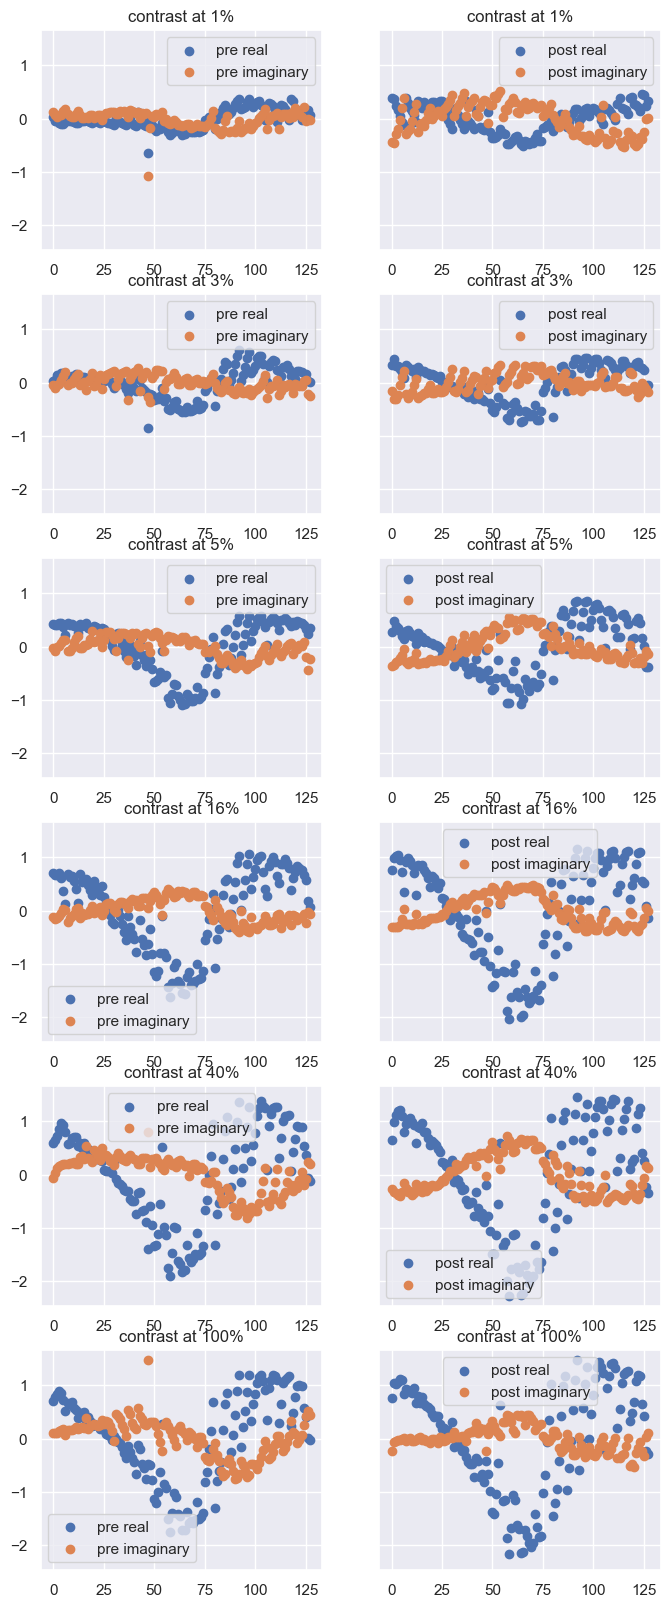

In [10]:
dataVis = SubjectRealIMaginaryActivityPerChannel[0][10,:,:,:]

fig,axs = plt.subplots(6,2,figsize = (8,20),sharey = True)
for c in range(NumBins):
    for ppsi in range(2): # pre post set index
        for re_im in range(2):
            pltData = dataVis[c,ppsi,re_im]
            axs[c,ppsi].scatter(chan_arr,pltData, label = f'{coStatus[ppsi]} {riStatus[re_im]}')
            axs[c,ppsi].legend()
            axs[c,ppsi].set_title(f'contrast at {cll[c]}')

In [11]:
Harmonic_Data_Ind = 0
FxData = [SubjectRealIMaginaryActivityPerChannel[Harmonic_Data_Ind],SubjectRealIMaginaryActivityPerChannel[Harmonic_Data_Ind+4]]
print(FxData[0].shape)

(50, 6, 2, 2, 128)


### Pick Data to export, and data to figure out how to expoert later for exlusion

In [12]:
DataOut = {}
DataOut['RIVals'] = SubjectRealIMaginaryActivityPerChannel
# DataOut['SubjNames'] = 
# DataOut['GoodSubjBool'] = 
# DataOut['AttnXiInd'] = 


In [13]:
SaveDataDir = 'C:\\plimon\\LTP_analysis\\ComplexValues_Data'
print(os.path.exists(SaveDataDir)) # does pth exist :p

dnt = datetime.now() # add date and time bc im wreckless when saving ..
fdnt = dnt.strftime("%Y%m%d_%H%M%S") # set the above as a string ...
FileOutName = 'AllSubj_RealImagData_C1'
FileN = f'{FileOutName}_{fdnt}.pkl' 
NewFileNPath = os.path.join(SaveDataDir,FileN)
print('Full New File Dir: ', NewFileNPath)

saveFile = 'y'
if saveFile == 'y':
 with open(NewFileNPath, 'wb') as file:
    pkl.dump(DataOut, file, protocol=pkl.HIGHEST_PROTOCOL)
    print('MAT Data For All Subjs Saved! :))')
else:
    print('Did Not Save File! Change file name before switching to y!')
print(os.path.exists(SaveDataDir)) # does pth exist :p

True
Full New File Dir:  C:\plimon\LTP_analysis\ComplexValues_Data\AllSubj_RealImagData_C1_20240502_172718.pkl
MAT Data For All Subjs Saved! :))
True


#### Save as .mat file for matlab stats 

In [16]:
save = 'no'

if save == 'y':

    SaveDataDir = 'C:\\plimon\\LTP_analysis\\ComplexValues_Data'
    print(os.path.exists(SaveDataDir)) # does pth exist :p

    CoStrings = ['2F1','4F1','6F1','8F1','2F2','4F2','6F2','8F2']

    dnt = datetime.now() # add date and time bc im wreckless when saving ..
    fdnt = dnt.strftime("%Y%m%d_%H%M%S") # set the above as a string ...

    for i in range(8):
        FileOutName = f'AllSubj_RealImagDataCo_{CoStrings[i]}'
        dataExport = np.array(SubjectRealIMaginaryActivityPerChannel[i])
        MatFileN = f'{FileOutName}_{fdnt}.mat' 
        NewMatFileNPath = os.path.join(SaveDataDir,MatFileN)
        print('Full New File Dir: ', NewFileNPath)
        hdf5_file = h5py.File(NewMatFileNPath, 'w')
        hdf5_file.create_dataset('data', data=dataExport)
        hdf5_file.close()
        print(f'Data saved as {NewMatFileNPath}')
else:
    print(f'No Data Saved, switch to Y')

No Data Saved, switch to Y


In [17]:
stats_test = SubjectRealIMaginaryActivityPerChannel[0]
print(stats_test.shape)

(50, 6, 2, 2, 128)


In [19]:
import numpy as np
from scipy.stats import chi2, f

def mbox(data1, data2, alphaVal):
    n1 = data1.shape[0]
    n2 = data2.shape[0]

    S1 = np.cov(data1, rowvar=False)
    S2 = np.cov(data2, rowvar=False)

    p = data1.shape[1]  # Number of columns
    g = 2  # Number of groups

    S12 = ((n1 - 1) * S1 + (n2 - 1) * S2) / (n1 - 1 + n2 - 1)
    Fstat = (n1 - 1) * np.log(np.linalg.det(S1)) + (n2 - 1) * np.log(np.linalg.det(S2))
    MB = (n1 - 1 + n2 - 1) * np.log(np.linalg.det(S12)) - Fstat

    sum1 = 1 / (n1 - 1) + 1 / (n2 - 1)
    sum2 = 1 / ((n1 - 1) ** 2) + 1 / ((n2 - 1) ** 2)

    # F-test or Chi-test approximation depending on sample size
    bw_cutoff = 20
    useApprox = 'Chi2'
    if n1 > bw_cutoff or n2 > bw_cutoff:
        useApprox = 'F'

    # Correction factor
    cFactor = (((2 * p ** 2) + 3 * p - 1) / (6 * (p + 1) * (g - 1))) * (sum1 - 1 / (n1 - 1 + n2 - 1))

    if useApprox == 'Chi2':
        # Chi-square approximation
        X2 = MB * (1 - cFactor)
        v = (p * (p + 1) * (g - 1)) / 2  # Degrees of freedom
        pVal = 1 - chi2.cdf(X2, v)
    elif useApprox == 'F':
        C0 = (sum2 - 1 / (n1 - 1 + n2 - 1) ** 2) * (p - 1) * (p + 2) / (6 * (g - 1))
        cDiff = C0 - cFactor ** 2
        v1 = p * (p + 1) * (g - 1) / 2  # Numerator degrees of freedom

        if cDiff >= 0:
            v21 = int((v1 + 2) / cDiff)  # Denominator degrees of freedom
            Fstat = MB * (1 - cFactor - (v1 / v21)) / v1  # F approximation
            pVal = 1 - f.cdf(Fstat, v1, v21)
        else:
            v22 = int(-(v1 + 2) / cDiff)  # Denominator degrees of freedom
            b = v22 / (1 - cFactor - 2 / v22)
            Fstat = (v22 * MB) / (v1 * (b - MB))  # F approximation
            pVal = 1 - f.cdf(Fstat, v1, v22)

    sig_diff = 0
    if pVal < alphaVal:
        sig_diff = 1

    return sig_diff, pVal

In [20]:
def eigFourierCoefs(xyData):
    dims = xyData.shape
    N = dims[0]

    if dims[1] != 2:
        raise ValueError('Input data must be a matrix of 2D row samples')
    if N < 2:
        raise ValueError('Input data must contain at least 2 samples')

    srIx = 0
    siIx = 1

    sampMu = np.mean(xyData, axis=0)
    sampCovMat = np.cov(xyData[:, [srIx, siIx]].T)

    eigenval, eigenvec = np.linalg.eig(sampCovMat)

    # Sort the eigenvectors by their eigenvalues
    eigAscendIx = np.argsort(eigenval)
    smaller_eigenvec = eigenvec[:, eigAscendIx[0]]
    larger_eigenvec = eigenvec[:, eigAscendIx[1]]
    smaller_eigenval = eigenval[eigAscendIx[0]]
    larger_eigenval = eigenval[eigAscendIx[1]]

    phi = np.arctan2(larger_eigenvec[1], larger_eigenvec[0])
    # Ensure phi is between 0 and 2*pi
    if phi < 0:
        phi += 2 * np.pi

    return sampMu, sampCovMat, smaller_eigenvec, smaller_eigenval, larger_eigenvec, larger_eigenval, phi


In [39]:
import numpy as np
from scipy.stats import f as f_dist
from scipy.stats import f_oneway

def t2FC(xyData1, xyData2, testMu=[0, 0], alphaVal=0.05, pdStyle=False):
    # Dimensions of xyData1
    dims = xyData1.shape

    if dims[0] < 2:
        raise ValueError('Input data must contain at least 2 samples')
    if dims[1] != 2:
        print('Input data should be a matrix of 2D row samples')

    # Ensure there is a third dimension
    if len(dims) < 3:
        xyData1 = np.concatenate((xyData1, np.zeros_like(xyData1)), axis=2)
        xyData2 = np.concatenate((xyData2, np.zeros_like(xyData2)), axis=2)
    elif dims[2] > 2:
        print('Length of the third dimension of input data may not exceed two')

    opt = {
        'testMu': np.zeros(dims[1]),
        'alphaVal': alphaVal,
        'pdStyle': pdStyle
    }

    # Remove NaNs
    d1 = xyData1[:, :, 0] - xyData1[:, :, 1]
    d2 = xyData2[:, :, 0] - xyData2[:, :, 1]

    dData1 = d1[~np.any(np.isnan(d1), axis=1)]
    dData2 = d2[~np.any(np.isnan(d2), axis=1)]

    n1 = dData1.shape[0]
    n2 = dData2.shape[0]

    try:
        sMu1, sCov1 = eigFourierCoefs(dData1)
        sMu2, sCov2 = eigFourierCoefs(dData2)
    except:
        print('The covariance matrix of xyData could not be calculated, probably your data do not contain >1 sample.')
        sCov1 = np.cov(dData1, rowvar=False)
        sCov2 = np.cov(dData2, rowvar=False)
        sMu1 = np.mean(dData1, axis=0)
        sMu2 = np.mean(dData2, axis=0)

    results = {'alpha': opt['alphaVal']}

    p = xyData1.shape[1]
    df1 = p
    df2 = n1 + n2 - p - 1
    t0Sqrd = (((n1 + n2 - 2) * p) / df2) * f_dist.ppf(1 - opt['alphaVal'], df1, df2)
    results['tSqrdCritical'] = t0Sqrd

    alphaVal = 0.01
    sig_diff, pVal = mbox(dData1, dData2, alphaVal)
    diff_mu = sMu1 - sMu2

    if not sig_diff:  # If covariance matrices are not significantly different
        print("Matrices not significantly different")
        S_pool = ((n1 - 1) * sCov1 + (n2 - 1) * sCov2) / (n1 - 1 + n2 - 1)
        diff_S_pool = S_pool * (1 / n1 + 1 / n2)
        invCovMat = np.linalg.inv(diff_S_pool)
        results['tSqrd'] = np.dot(np.dot(diff_mu - opt['testMu'], invCovMat), diff_mu - opt['testMu'])
        tSqrdF = results['tSqrd'] * (df2 / (df1 * (df2 + 1)))
        results['pVal'] = 1 - f_dist.cdf(tSqrdF, df1, df2)
    else:  # Unequal covariance matrices
        print("Matrices significantly different")
        S_pool = sCov1 / n1 + sCov2 / n2
        diff_mu = sMu1 - sMu2
        invCovMat = np.linalg.inv(S_pool)
        results['tSqrd'] = np.dot(np.dot(diff_mu - opt['testMu'], invCovMat), diff_mu - opt['testMu'])
        tSqrdF = results['tSqrd'] * (n1 + n2 - 1 - p) / (p * (n1 - 1 + n2 - 1))
        df1 = p
        s1 = np.dot(np.dot(diff_mu - opt['testMu'], invCovMat), (sCov1 / n1))
        s2 = np.dot(np.dot(diff_mu - opt['testMu'], invCovMat), (sCov2 / n2))
        df2 = results['tSqrd']**2 / (s1**2 / (n1 - 1) + s2**2 / (n2 - 1))
        F_Crit = f_dist.ppf(opt['alphaVal'], df1, df2)
        results['pVal'] = 1 - f_dist.cdf(tSqrdF, df1, df2)

    results['H'] = int(tSqrdF >= results['tSqrdCritical'])

    return results

#### Test to run some stats tests

In [49]:
print(stats_test.shape)

dataIn = stats_test[:,0,0,:,:] # subs x contrasts x pre/post x real/ imaginary x channels

dataIn2 = stats_test[:,0,1,:,:]
print(dataIn.shape)

(50, 6, 2, 2, 128)
(50, 2, 128)


In [29]:
# x,c,v,b,n,m,s = eigFourierCoefs(dataIn)
# # 50 x array
# print(x.shape)
# print(x)

# print(c.shape)
# print(c)

# print(v.shape)
# print(v)

# print(b.shape)
# print(b)

# print(n.shape)
# print(n)

# print(m.shape)
# print(m)

# print(s.shape)
# print(s)

(2,)
[-0.17422648 -0.0931445 ]
(2, 2)
[[ 0.03374109 -0.00157661]
 [-0.00157661  0.02988951]]
(2,)
[0.33632695 0.94174529]
()
0.02932645804208228
(2,)
[ 0.94174529 -0.33632695]
()
0.03430414840586942
()
5.940171398060734


In [30]:
# alphaVal = 0.05
# xy, pv = mbox(dataIn, dataIn, alphaVal)

In [37]:
# print(xy)
# print(pv)
print(dataIn.shape)

(50, 2)


In [53]:
testMu = np.array([0,0])
alphaVal = 0.05

results = t2FC(dataIn,dataIn2,testMu, alphaVal)
print("Results of t2FC test:", results)

Length of the third dimension of input data may not exceed two
The covariance matrix of xyData could not be calculated, probably your data do not contain >1 sample.
Matrices not significantly different
Results of t2FC test: {'alpha': 0.05, 'tSqrdCritical': 6.244088539488174, 'tSqrd': 1.7032917174341582, 'pVal': 0.4335648586033405, 'H': 0}
